# Toy problem
## Contents
[1. Linear data](#S1)
* [1.1 Generate data](#S11)
* [1.2 Evaluate algorithms](#S12)
    * [1.2.1 Linear regression](#S121)
    * [1.2.2 Regression forest](#S122)
    * [1.2.3 Gaussian process](#S123)
    * [1.2.4 K-means](#S124)
    
[2. Non-linear data](#S2)
* [2.1 Generate data](#S21)
* [2.2 Evaluate algorithms](#S22)
    * [2.2.1 Linear regression](#S221)
    * [2.2.2 Regression forest](#S222)
    * [2.2.3 Gaussian process](#S223)
    * [2.2.4 K-means](#S224) 
    
[3. Summary](#S3)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time
import seaborn as sns
from algorithms import linear_regression, regression_forest, fit_gaussian, k_means
from optimisers import brute_force_optimiser, GP_Optimiser

<a id='S1'></a>
# 1. Linear data

<a id='S11'></a>
## 1.1 Generate data 

In [2]:
def gen_lin_data(N, noise_variance=3):
    np.random.seed(42)
    x = np.random.uniform(-6,6,(N,1))
    y = -3+5*x+ np.random.randn(N,1) * noise_variance
    return x, y

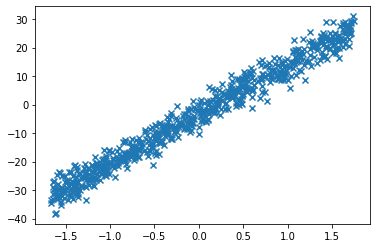

In [3]:
# Generate 1000 points of linear data...
x_lin, y_lin = gen_lin_data(1000)

# Standardize...
x_lin_std = (x_lin - np.mean(x_lin, axis=0))/np.std(x_lin, axis=0)

# Test/Validate/Train split
total_count = x_lin_std.shape[0]
train_split = int(total_count * 0.7)
val_split = int(total_count * 0.85)
np.random.seed(42)
shuffle = np.random.permutation(total_count)
x_lin_train = x_lin_std[shuffle][:train_split]
x_lin_val = x_lin_std[shuffle][train_split:val_split]
x_lin_test = x_lin_std[shuffle][val_split:]
y_lin_train = y_lin[shuffle][:train_split]
y_lin_val = y_lin[shuffle][train_split:val_split]
y_lin_test = y_lin[shuffle][val_split:]
plt.scatter(x_lin_train,y_lin_train, marker='x');

# plt.savefig('Figure 4a - Linear data plot.png')

In [4]:
# Generate noiseless data (for visualisations)...
x_linTrue, y_linTrue = gen_lin_data(1000, noise_variance=0)
x_linTrue_std = (x_linTrue - np.mean(x_linTrue, axis=0))/np.std(x_linTrue, axis=0)

<a id='S12'></a>
## 1.2 Evaluate algorithms

<a id='S121'></a>
### 1.2.1 Linear regression

In [5]:
lambda_ = 1
TP_lin_reg_result = linear_regression(x_lin_train, y_lin_train, x_lin_test, y_lin_test, lambda_)
TP_lin_reg_R2 = 1 - (TP_lin_reg_result['Test RMSE'] / y_lin_test.std())**2
print(f"Linear regression without regularisation:")
print(f" Train RMSE: {TP_lin_reg_result['Train RMSE']:.02f}")
print(f" Test RMSE: {TP_lin_reg_result['Test RMSE']:.02f}")
print(f" Test R2: {TP_lin_reg_R2:.02f}")

Linear regression without regularisation:
 Train RMSE: 2.91
 Test RMSE: 3.03
 Test R2: 0.97


In [6]:
# Tune lambda...
lb = [0]
ub = [50]
res = 100
start = time.time()
TP_lin_reg_result_opt = brute_force_optimiser(linear_regression, x_lin_train, y_lin_train, x_lin_val, y_lin_val, x_lin_test, y_lin_test, lb, ub, res=res)
TP_lin_reg_opt_R2 = 1 - (TP_lin_reg_result_opt['Test RMSE'] / y_lin_test.std())**2
total_time = time.time() - start
print(f"Linear regression with ridge regularisation:")
print(f" Optimal validate RMSE: {TP_lin_reg_result_opt['Val RMSE']:.02f} using lambda of {TP_lin_reg_result_opt['Optimal HP']:.02f}")
print(f" Corresponding test RMSE: {TP_lin_reg_result_opt['Test RMSE']:.02f}")
print(f" Test R2: {TP_lin_reg_opt_R2:.02f}")
print(f" Optimisation took {total_time:.02f} seconds for an R2 improvement of {TP_lin_reg_opt_R2-TP_lin_reg_R2:.02f} ({(TP_lin_reg_opt_R2-TP_lin_reg_R2)*100/TP_lin_reg_R2:.02f}%)")

Linear regression with ridge regularisation:
 Optimal validate RMSE: 3.15 using lambda of 0.00
 Corresponding test RMSE: 3.03
 Test R2: 0.97
 Optimisation took 0.13 seconds for an R2 improvement of 0.00 (0.00%)


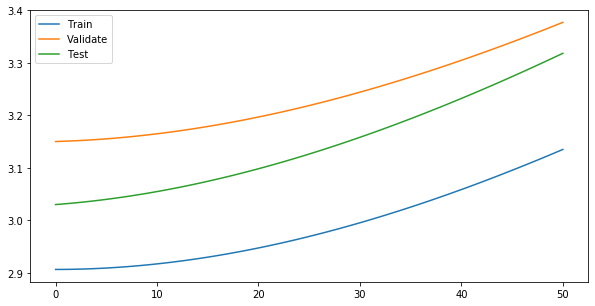

In [7]:
fig = plt.figure(figsize = (10, 5))
plt.plot(np.linspace(lb[0],ub[0],res),TP_lin_reg_result_opt['RMSE plot'][:,0], label="Train");
plt.plot(np.linspace(lb[0],ub[0],res),TP_lin_reg_result_opt['RMSE plot'][:,1], label="Validate");
plt.plot(np.linspace(lb[0],ub[0],res),TP_lin_reg_result_opt['RMSE plot'][:,2], label="Test");
plt.legend();

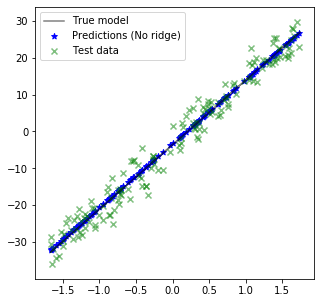

In [8]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_lin_test, TP_lin_reg_result['test_preds'], marker='*', color='b', label='Predictions (No ridge)')
#plt.scatter(x_lin_test, TP_lin_reg_result_opt['test_preds'], marker='+', color='r', label='Predictions (ridge)')
plt.scatter(x_lin_test, y_lin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.plot(x_linTrue_std, y_linTrue, color='black', alpha=0.5, label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 5a - LinReg lin perf.png')

<a id='S122'></a>
### 1.2.2 Regression forest
* Note `hps` contains the hyper parameters in the positions `[max depth, alpha, gamma]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [9]:
# Use arbitrary hyperparameters...
hps = [3, 150, 100]
start = time.time()
TP_reg_forest = regression_forest(x_lin_train, 
                                  y_lin_train, 
                                  x_lin_test, 
                                  y_lin_test, 
                                  hps, 
                                  kwargs={'k':x_lin_train.shape[0],
                                               'no_trees':20,
                                         'run_concurrent': True})
reg_forest_time = time.time() - start
TP_reg_forest_R2 = 1 - (TP_reg_forest['Test RMSE'] / y_lin_test.std())**2
print(f"Regression forest with arbitrary hyperparameters:")
print(f" Train RMSE: {TP_reg_forest['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {TP_reg_forest['OOB RMSE']:.02f}")
print(f" Test RMSE: {TP_reg_forest['Test RMSE']:.02f}")
print(f" Test R2: {TP_reg_forest_R2:.02f}")
print(f" Forest built in {reg_forest_time/60:.02f} mins")

Regression forest with arbitrary hyperparameters:
 Train RMSE: 4.39
 Out of bag RMSE: 5.09
 Test RMSE: 4.22
 Test R2: 0.95
 Forest built in 0.06 mins


In [10]:
# Tune max depth and alpha...
lbs = [3, 1, 50]
ubs = [20, 150, 150]
res = 16
opt_steps = 10
start = time.time()
TP_reg_forest_opt = GP_Optimiser(regression_forest, 
                              x_lin_train, 
                              y_lin_train, 
                              x_lin_val, 
                              y_lin_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps,
                              kwargs = {'k': x_lin_train.shape[0],
                                       'no_trees': 20,
                                       'run_concurrent': False})
opt_time = time.time() - start
print(f"Optimal max tree depth: {int(TP_reg_forest_opt['Optimal Hyperparameters'][0])}, optimal alpha: {TP_reg_forest_opt['Optimal Hyperparameters'][1]:.02f}, , optimal gamma: {TP_reg_forest_opt['Optimal Hyperparameters'][2]:.02f}")
print(f"{len(TP_reg_forest_opt['All RMSEs'])-2} optimisation steps took {opt_time/60:.02f} mins")
print(f"Improvement over random guess: {TP_reg_forest_opt['All RMSEs'][0][0]-TP_reg_forest_opt['Optimal RMSE']:.02f}")

Using Bayesian optimisation...
Completed step 1 in 7.43 seconds.
Completed step 2 in 7.33 seconds.
Completed step 3 in 7.02 seconds.
Completed step 4 in 7.40 seconds.
Completed step 5 in 7.25 seconds.
Completed step 6 in 7.12 seconds.
Completed step 7 in 6.93 seconds.
Optimal max tree depth: 6, optimal alpha: 120.20, , optimal gamma: 130.00
7 optimisation steps took 1.08 mins
Improvement over random guess: 0.01


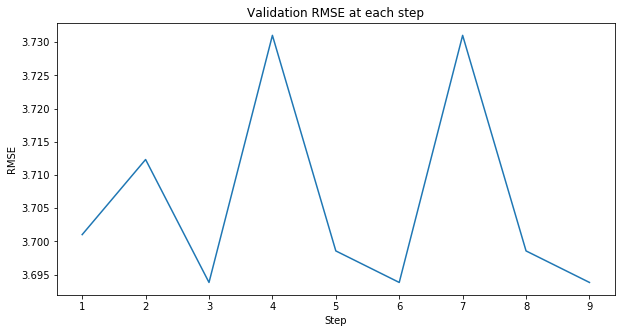

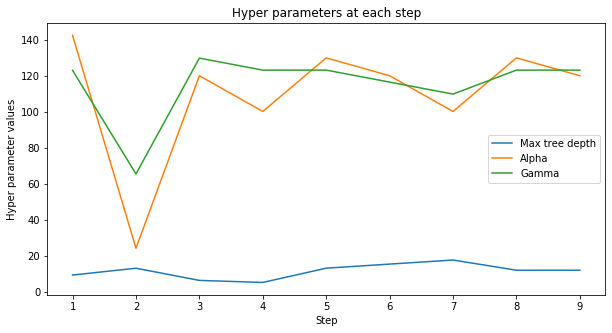

In [11]:
fig = plt.figure(figsize = (10, 5))
plt.plot(range(1,len(TP_reg_forest_opt['All RMSEs'])+1), TP_reg_forest_opt['All RMSEs']);
plt.title("Validation RMSE at each step")
plt.xlabel('Step')
plt.ylabel('RMSE');

fig = plt.figure(figsize = (10, 5))
plt.plot(range(1,len(TP_reg_forest_opt['All HP steps'][:,0])+1), TP_reg_forest_opt['All HP steps'][:,0], label ="Max tree depth");
plt.plot(range(1,len(TP_reg_forest_opt['All HP steps'][:,1])+1), TP_reg_forest_opt['All HP steps'][:,1], label ="Alpha");
plt.plot(range(1,len(TP_reg_forest_opt['All HP steps'][:,1])+1), TP_reg_forest_opt['All HP steps'][:,2], label ="Gamma")
plt.title("Hyper parameters at each step")
plt.xlabel('Step')
plt.ylabel('Hyper parameter values');
plt.legend();

In [12]:
# Evaluate forest with optimal HPs on test data...
opt_hps = TP_reg_forest_opt['Optimal Hyperparameters']
TP_reg_forest_opt_test = regression_forest(x_lin_train, 
                                           y_lin_train, 
                                           x_lin_test, 
                                           y_lin_test,
                                           opt_hps, 
                                           kwargs = {'k': x_lin_train.shape[0],
                                                    'no_trees': 20,
                                                    'run_concurrent': False})
TP_opt_reg_forest_R2 = 1 - (TP_reg_forest_opt_test['Test RMSE'] / y_lin_test.std())**2

print(f"Regression forest with optimal hyperparameters:")
print(f" Train RMSE: {TP_reg_forest_opt_test['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {TP_reg_forest_opt_test['OOB RMSE']:.02f}")
print(f" Test RMSE: {TP_reg_forest_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {TP_opt_reg_forest_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {TP_opt_reg_forest_R2-TP_reg_forest_R2:.02f} (+{(TP_opt_reg_forest_R2-TP_reg_forest_R2)*100/TP_opt_reg_forest_R2:.02f}%)")

Regression forest with optimal hyperparameters:
 Train RMSE: 2.80
 Out of bag RMSE: 3.23
 Test RMSE: 3.31
 Test R2: 0.97
 R2 improvement over arbitray HPs R2: 0.02 (+2.19%)


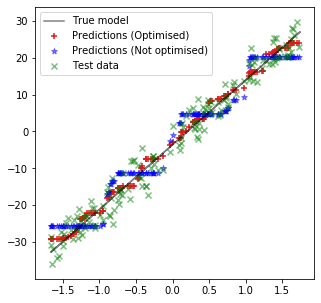

In [13]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_lin_test, TP_reg_forest_opt_test['test_pred'], marker='+', color='#DE1A1A', label='Predictions (Optimised)')
plt.scatter(x_lin_test, TP_reg_forest['test_pred'], marker='*', color='b', alpha=0.5,label='Predictions (Not optimised)')
plt.scatter(x_lin_test, y_lin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.plot(x_linTrue_std, y_linTrue, color='black', alpha=0.5, label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 6a - RegFor lin perf.png')

<a id='S123'></a>
### 1.2.3 Gaussian process
* Note `hps` contains the hyper parameters in the positions `[lengthscale, amplitude, noise variance]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [14]:
# Fit guassian with arbitrary hyperparameters
hps = [1,1,1]
TP_gaussian_result = fit_gaussian(x_lin_train, y_lin_train, x_lin_test, y_lin_test, hps, rtn_RMSE = True)
TP_gp_R2 = 1 - (TP_gaussian_result['Test RMSE'] / y_lin_test.std())**2
print(f"Gaussian process with arbitrary hyperparameters:")
print(f" Test RSME: {TP_gaussian_result['Test RMSE']:.02f}")
print(f" Test R2: {TP_gp_R2:.02f}")

Gaussian process with arbitrary hyperparameters:
 Test RSME: 3.06
 Test R2: 0.97


In [15]:
lbs = [1e-6,1e-6,1e-6]
ubs = [50,50,10]
opt_steps=10
res = 15
start = time.time()
TP_gp_opt = GP_Optimiser(fit_gaussian, 
                              x_lin_train, 
                              y_lin_train, 
                              x_lin_val, 
                              y_lin_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps)

opt_time = time.time() - start
print(f"Optimal lengthscale: {TP_gp_opt['Optimal Hyperparameters'][0]}, Optimal amplitude: {TP_gp_opt['Optimal Hyperparameters'][1]:.02f},Optimal noise varaince: {TP_gp_opt['Optimal Hyperparameters'][2]:.02f}")
# print(f"{len(TP_gp_opt['All RMSEs']-2)} optimisation steps took {opt_time/60:.02f} mins")
# print(f"Improvement over random guess: {(TP_gp_opt['All RMSEs'][0][0]-TP_gp_opt['Optimal RMSE'])*100/TP_gp_opt['All RMSEs'][0][0]:0.2f}%")

Using Bayesian optimisation...
Completed step 1 in 0.57 seconds.
Completed step 2 in 0.49 seconds.
Completed step 3 in 0.55 seconds.
Optimal lengthscale: 39.2857145, Optimal amplitude: 14.29,Optimal noise varaince: 2.86


In [16]:
# fig = plt.figure(figsize = (10, 5))
# plt.plot(range(1,len(TP_gp_opt['All RMSEs'])+1), TP_gp_opt['All RMSEs']);
# plt.title("Validation RMSE at each step")
# plt.xlabel('Step')
# plt.ylabel('RMSE');

# fig = plt.figure(figsize = (10, 5))
# plt.plot(range(1,len(TP_gp_opt['All HP steps'][:,0])+1), TP_gp_opt['All HP steps'][:,0], label ="Lengthscale");
# plt.plot(range(1,len(TP_gp_opt['All HP steps'][:,1])+1), TP_gp_opt['All HP steps'][:,1], label ="Amplitude");
# plt.plot(range(1,len(TP_gp_opt['All HP steps'][:,1])+1), TP_gp_opt['All HP steps'][:,2], label ="Noise variance");
# plt.title("Hyper parameters at each step")
# plt.xlabel('Step')
# plt.ylabel('Hyper parameter values');
# plt.legend(bbox_to_anchor=(1.05, 1));

In [17]:
# Evaluate GP with optimal HPs on test data...
opt_hps = TP_gp_opt['Optimal Hyperparameters']
TP_gp_opt_test = fit_gaussian(x_lin_train, y_lin_train, x_lin_test, y_lin_test, opt_hps, rtn_RMSE = True)
TP_gp_opt_test_R2 = 1 - (TP_gp_opt_test['Test RMSE'] / y_lin_test.std())**2
print(f"Gaussian process with optimal hyperparameters:")
print(f" Test RMSE: {TP_gp_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {TP_gp_opt_test_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {TP_gp_opt_test_R2-TP_gp_R2:.02f} (+{(TP_gp_opt_test_R2-TP_gp_R2)*100/TP_gp_R2:.02f}%)")

Gaussian process with optimal hyperparameters:
 Test RMSE: 3.03
 Test R2: 0.97
 R2 improvement over arbitray HPs R2: 0.00 (+0.05%)


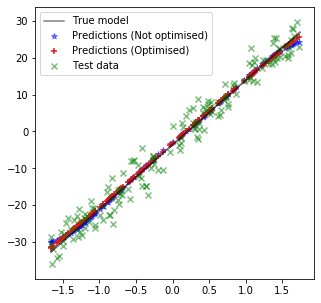

In [18]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_lin_test, TP_gaussian_result['test_preds'], marker='*', color='b', label='Predictions (Not optimised)', alpha=0.5)
plt.scatter(x_lin_test, TP_gp_opt_test['test_preds'], marker='+', color='#DE1A1A', label='Predictions (Optimised)')
plt.scatter(x_lin_test, y_lin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.plot(x_linTrue_std, y_linTrue, color='black', alpha=0.5, label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 7a - GP lin perf.png')

<a id='S124'></a>
### K-means

In [19]:
# K-means without tuning k...
k = 10
TP_kmeans_result = k_means(x_lin_train, y_lin_train, x_lin_test, y_lin_test, k=k)
TP_kmeans_result_R2 = 1 - (TP_kmeans_result['Test RMSE'] / y_lin_test.std())**2
print(f"K-means with arbitrary k:")
print(f" Train RMSE: {TP_kmeans_result['Train RMSE']:.02f}")
print(f" Test RMSE: {TP_kmeans_result['Test RMSE']:.02f}")
print(f" Test R2: {TP_kmeans_result_R2:.02f}")

K-means with arbitrary k:
 Train RMSE: 3.66
 Test RMSE: 3.82
 Test R2: 0.96


In [20]:
# Tune k...
lb = [1]
ub = [100]
res = 100
start = time.time()
TP_kmeans_opt = brute_force_optimiser(k_means, 
                                      x_lin_train, 
                                      y_lin_train, 
                                      x_lin_val, 
                                      y_lin_val, 
                                      x_lin_test, 
                                      y_lin_test, 
                                      lb, 
                                      ub, 
                                      res=res)
TP_kmeans_opt_R2 = 1 - (TP_kmeans_opt['Test RMSE'] / y_lin_test.std())**2
total_time = time.time() - start
print(f"K-means with tuned k:")
print(f" Optimal validate RMSE: {TP_kmeans_opt['Val RMSE']:.02f} using k of {TP_kmeans_opt['Optimal HP']:.00f}")
print(f" Corresponding test RMSE: {TP_kmeans_opt['Test RMSE']:.02f}")
print(f" Test R2: {TP_kmeans_opt_R2:.02f}")
print(f" Optimisation took {total_time:.02f} seconds for an R2 improvement of {TP_kmeans_opt_R2-TP_kmeans_result_R2:.02f} (+{(TP_kmeans_opt_R2-TP_kmeans_result_R2)*100/TP_kmeans_result_R2:0.2f}%)")

/Users/chrismcdonagh/Documents/Data Science /Machine Learning 1/Labs/ML-1-labs/Lab 5 (Project)/DL check/algorithms.py:383: RuntimeWarning: divide by zero encountered in true_divide
  [np.sum(1 / (distances[P == i])) for i in range(k)])


K-means with tuned k:
 Optimal validate RMSE: 3.34 using k of 31
 Corresponding test RMSE: 3.35
 Test R2: 0.97
 Optimisation took 6.94 seconds for an R2 improvement of 0.01 (+1.09%)


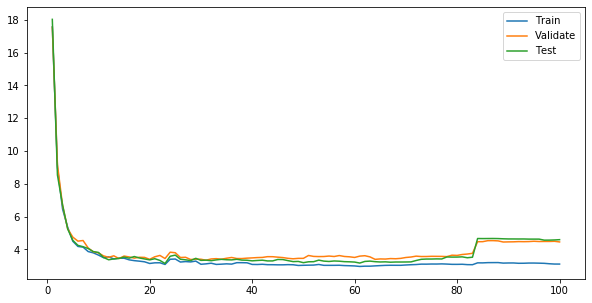

In [21]:
fig = plt.figure(figsize = (10, 5))
plt.plot(np.linspace(lb[0],ub[0],res),TP_kmeans_opt['RMSE plot'][:,0], label="Train");
plt.plot(np.linspace(lb[0],ub[0],res),TP_kmeans_opt['RMSE plot'][:,1], label="Validate");
plt.plot(np.linspace(lb[0],ub[0],res),TP_kmeans_opt['RMSE plot'][:,2], label="Test");
plt.legend();

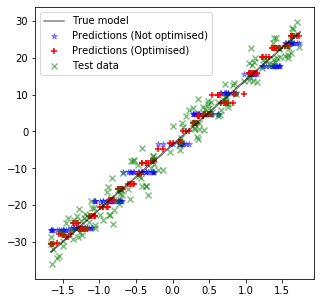

In [22]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_lin_test, TP_kmeans_result['test_preds'], marker='*', color='b', label='Predictions (Not optimised)', alpha=0.4)
plt.scatter(x_lin_test, TP_kmeans_opt['test_preds'], marker='+', color='r', label='Predictions (Optimised)')
plt.scatter(x_lin_test, y_lin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.plot(x_linTrue_std, y_linTrue, color='black', alpha=0.5, label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 8a - kmeans lin perf.png')

<a id='S2'></a>
#  2. Non-linear data

<a id='S21'></a>
## 2.1 Generate data

In [23]:
def gen_nlin_data(N, noise_variance=3):
    np.random.seed(42)
    x = np.random.uniform(-6,6,(N,1))
    y = 5*np.sin(x) + np.random.randn(N,1) * noise_variance
    return x, y

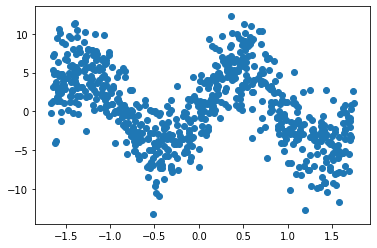

In [24]:
# Generate 1000 points of linear data...
x_nlin, y_nlin = gen_nlin_data(1000)

# Standardize...
x_nlin_std = (x_nlin - np.mean(x_nlin, axis=0))/np.std(x_nlin, axis=0)

# Test/Validate/Train split
total_count = x_nlin_std.shape[0]
train_split = int(total_count * 0.7)
val_split = int(total_count * 0.85)
np.random.seed(42)
shuffle = np.random.permutation(total_count)
x_nlin_train = x_nlin_std[shuffle][:train_split]
x_nlin_val = x_nlin_std[shuffle][train_split:val_split]
x_nlin_test = x_nlin_std[shuffle][val_split:]
y_nlin_train = y_nlin[shuffle][:train_split]
y_nlin_val = y_nlin[shuffle][train_split:val_split]
y_nlin_test = y_nlin[shuffle][val_split:]
plt.scatter(x_nlin_train,y_nlin_train);

# plt.savefig('Figure 4b - Non-linear data plot.png')

In [25]:
# Generate noiseless data (for visualisations)...
x_nlinTrue, y_nlinTrue = gen_nlin_data(1000, noise_variance=0)
x_nlinTrue_std = (x_nlinTrue - np.mean(x_nlinTrue, axis=0))/np.std(x_nlinTrue, axis=0)

<a id='S22'></a>
## 2.2 Evaluate algorithms

<a id='S221'></a>
### 2.2.1 Linear regression

In [26]:
lambda_ = 1
TPnl_lin_reg_result = linear_regression(x_nlin_train, y_nlin_train, x_nlin_test, y_nlin_test, lambda_)
TPnl_lin_reg_R2 = 1 - (TPnl_lin_reg_result['Test RMSE'] / y_nlin_test.std())**2
print(f"Linear regression without regularisation:")
print(f" Train RMSE: {TPnl_lin_reg_result['Train RMSE']:.02f}")
print(f" Test RMSE: {TPnl_lin_reg_result['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_lin_reg_R2:.02f}")

Linear regression without regularisation:
 Train RMSE: 4.51
 Test RMSE: 4.78
 Test R2: 0.10


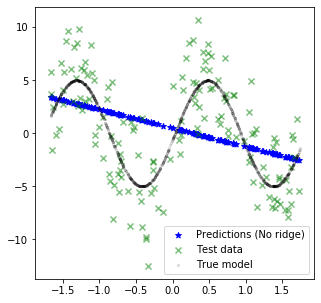

In [27]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_nlin_test, TPnl_lin_reg_result['test_preds'], marker='*', color='b', label='Predictions (No ridge)')
plt.scatter(x_nlin_test, y_nlin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.scatter(x_nlinTrue_std, y_nlinTrue, color='black', alpha=0.1, s=5, label='True model');
plt.legend();
ax = plt.gca()
ax.grid(False)

# plt.savefig('Figure 5b - LinReg non-lin perf.png')

<a id='S222'></a>
### 2.2.2 Regression forest
* Note `hps` contains the hyper parameters in the positions `[max depth, alpha, gamma]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [28]:
# Use arbitrary hyperparameters...
hps = [5, 150, 100]
start = time.time()
TPnl_reg_forest = regression_forest(x_nlin_train, 
                                  y_nlin_train, 
                                  x_nlin_test, 
                                  y_nlin_test, 
                                  hps, 
                                  kwargs={'k':x_nlin_train.shape[0],
                                               'no_trees':20,
                                         'run_concurrent': True})
reg_forest_time = time.time() - start
TPnl_reg_forest_R2 = 1 - (TPnl_reg_forest['Test RMSE'] / y_nlin_test.std())**2
print(f"Regression forest with arbitrary hyperparameters:")
print(f" Train RMSE: {TPnl_reg_forest['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {TPnl_reg_forest['OOB RMSE']:.02f}")
print(f" Test RMSE: {TPnl_reg_forest['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_reg_forest_R2:.02f}")
print(f" Forest built in {reg_forest_time/60:.02f} mins")

Regression forest with arbitrary hyperparameters:
 Train RMSE: 2.81
 Out of bag RMSE: 3.15
 Test RMSE: 3.05
 Test R2: 0.63
 Forest built in 0.08 mins


In [29]:
# Tune max depth and alpha...
lbs = [3, 50, 80]
ubs = [20, 200, 120]
res = 16
opt_steps = 10
start = time.time()
TPnl_reg_forest_opt = GP_Optimiser(regression_forest, 
                              x_nlin_train, 
                              y_nlin_train, 
                              x_nlin_val, 
                              y_nlin_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps,
                              kwargs = {'k': x_nlin_train.shape[0],
                                       'no_trees': 20,
                                       'run_concurrent': False})
opt_time = time.time() - start
print(f"Optimal max tree depth: {int(TPnl_reg_forest_opt['Optimal Hyperparameters'][0])}, optimal alpha: {TPnl_reg_forest_opt['Optimal Hyperparameters'][1]:.02f}, optimal gamma: {TPnl_reg_forest_opt['Optimal Hyperparameters'][2]:.02f}")
print(f"{len(TPnl_reg_forest_opt['All RMSEs'])-2} optimisation steps took {opt_time/60:.02f} mins")
print(f"Improvement over random guess: {TPnl_reg_forest_opt['All RMSEs'][0][0]-TPnl_reg_forest_opt['Optimal RMSE']}")

Using Bayesian optimisation...
Completed step 1 in 8.98 seconds.
Completed step 2 in 9.04 seconds.
Completed step 3 in 8.67 seconds.
Completed step 4 in 8.82 seconds.
Completed step 5 in 8.60 seconds.
Optimal max tree depth: 17, optimal alpha: 70.00, optimal gamma: 82.67
5 optimisation steps took 1.05 mins
Improvement over random guess: 0.01098429287160263


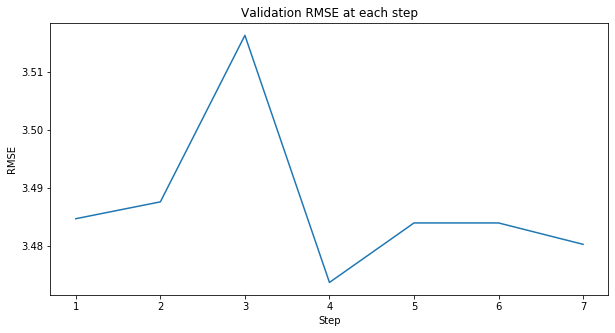

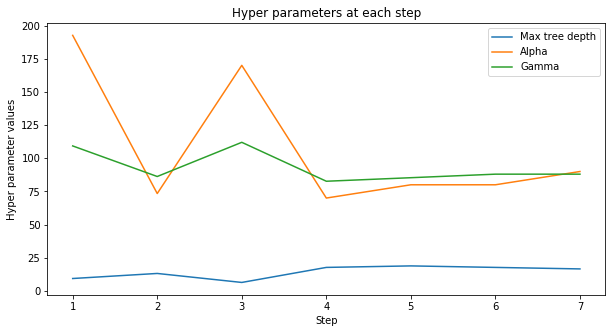

In [30]:
fig = plt.figure(figsize = (10, 5))
plt.plot(range(1,len(TPnl_reg_forest_opt['All RMSEs'])+1), TPnl_reg_forest_opt['All RMSEs']);
plt.title("Validation RMSE at each step")
plt.xlabel('Step')
plt.ylabel('RMSE');

fig = plt.figure(figsize = (10, 5))
plt.plot(range(1,len(TPnl_reg_forest_opt['All HP steps'][:,0])+1), TPnl_reg_forest_opt['All HP steps'][:,0], label ="Max tree depth");
plt.plot(range(1,len(TPnl_reg_forest_opt['All HP steps'][:,1])+1), TPnl_reg_forest_opt['All HP steps'][:,1], label ="Alpha");
plt.plot(range(1,len(TPnl_reg_forest_opt['All HP steps'][:,1])+1), TPnl_reg_forest_opt['All HP steps'][:,2], label ="Gamma")
plt.title("Hyper parameters at each step")
plt.xlabel('Step')
plt.ylabel('Hyper parameter values');
plt.legend();

In [31]:
# Evaluate forest with optimal HPs on test data...
opt_hps = TPnl_reg_forest_opt['Optimal Hyperparameters']
TPnl_reg_forest_opt_test = regression_forest(x_nlin_train, 
                                           y_nlin_train, 
                                           x_nlin_test, 
                                           y_nlin_test,
                                           opt_hps, 
                                           kwargs = {'k': x_nlin_train.shape[0],
                                                   'no_trees': 20,
                                                    'run_concurrent': False})
TPnl_opt_reg_forest_R2 = 1 - (TPnl_reg_forest_opt_test['Test RMSE'] / y_nlin_test.std())**2

print(f"Regression forest with optimal hyperparameters:")
print(f" Train RMSE: {TPnl_reg_forest_opt_test['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {TPnl_reg_forest_opt_test['OOB RMSE']:.02f}")
print(f" Test RMSE: {TPnl_reg_forest_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_opt_reg_forest_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {TPnl_opt_reg_forest_R2-TPnl_reg_forest_R2:.02f} (+{(TPnl_opt_reg_forest_R2-TPnl_reg_forest_R2)*100/TPnl_opt_reg_forest_R2:.02f}%)")

Regression forest with optimal hyperparameters:
 Train RMSE: 2.68
 Out of bag RMSE: 3.03
 Test RMSE: 3.02
 Test R2: 0.64
 R2 improvement over arbitray HPs R2: 0.01 (+1.37%)


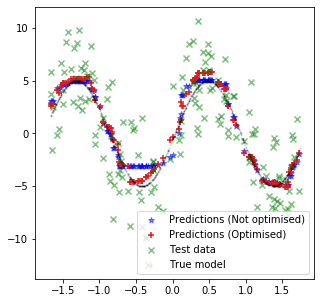

In [32]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_nlin_test, TPnl_reg_forest['test_pred'], marker='*', color='b', alpha=0.5,label='Predictions (Not optimised)')
plt.scatter(x_nlin_test, TPnl_reg_forest_opt_test['test_pred'], marker='+', color='#DE1A1A', label='Predictions (Optimised)')
plt.scatter(x_nlin_test, y_nlin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.scatter(x_nlinTrue_std, y_nlinTrue, color='black', marker='.',alpha=0.1, s=5, label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 6b - RegFor non-lin perf.png')

<a id='S223'></a>
### 2.2.3 Gaussian process
* Note `hps` contains the hyper parameters in the positions `[lengthscale, amplitude, noise variance]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [33]:
# Fit guassian with arbitrary hyperparameters
hps = [1,1,1]
TPnl_gaussian_result = fit_gaussian(x_nlin_train, y_nlin_train, x_nlin_test, y_nlin_test, hps, rtn_RMSE = True)
TPnl_gp_R2 = 1 - (TPnl_gaussian_result['Test RMSE'] / y_nlin_test.std())**2
print(f"Gaussian process with arbitrary hyperparameters:")
print(f" Test RSME: {TPnl_gaussian_result['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_gp_R2:.02f}")

Gaussian process with arbitrary hyperparameters:
 Test RSME: 3.38
 Test R2: 0.55


In [34]:
lbs = [1e-1,1e-1,1e-1]
ubs = [5,5,5]
opt_steps=10
res = 16
start = time.time()
TPnl_gp_opt = GP_Optimiser(fit_gaussian, 
                              x_nlin_train, 
                              y_nlin_train, 
                              x_nlin_val, 
                              y_nlin_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps,
                              check_mle=True)
opt_time = time.time() - start
print(f"Optimal lengthscale: {TPnl_gp_opt['Optimal Hyperparameters'][0]:.02f}, Optimal amplitude: {TPnl_gp_opt['Optimal Hyperparameters'][1]:.02f},Optimal noise varaince: {TPnl_gp_opt['Optimal Hyperparameters'][2]:.02f}")
print(f"Optimisation steps took {opt_time:.02f} secs")
# print(f"Improvement over random guess: {(TPnl_gp_opt['All RMSEs'][0][0]-TPnl_gp_opt['Optimal RMSE'])*100/TPnl_gp_opt['All RMSEs'][0][0]:0.2f}%")

Optimising using MLE...
Completed step 1 in: 0.13
Completed step 2 in: 0.12
Completed step 3 in: 0.10
Completed step 4 in: 0.12
Completed step 5 in: 0.12
Completed step 6 in: 0.11
Completed step 7 in: 0.11
Completed step 8 in: 0.12
Completed step 9 in: 0.12
Completed step 10 in: 0.10
Optimal lengthscale: 0.39, Optimal amplitude: 1.09,Optimal noise varaince: 6.08
Optimisation steps took 1.16 secs


In [35]:
# fig = plt.figure(figsize = (10, 5))
# plt.plot(range(1,len(TPnl_gp_opt['All RMSEs'])+1), TPnl_gp_opt['All RMSEs']);
# plt.title("Validation RMSE at each step")
# plt.xlabel('Step')
# plt.ylabel('RMSE');

# fig = plt.figure(figsize = (10, 5))
# plt.plot(range(1,len(TPnl_gp_opt['All HP steps'][:,0])+1), TPnl_gp_opt['All HP steps'][:,0], label ="Lengthscale");
# plt.plot(range(1,len(TPnl_gp_opt['All HP steps'][:,1])+1), TPnl_gp_opt['All HP steps'][:,1], label ="Amplitude");
# plt.plot(range(1,len(TPnl_gp_opt['All HP steps'][:,1])+1), TPnl_gp_opt['All HP steps'][:,2], label ="Noise variance");
# plt.title("Hyper parameters at each step")
# plt.xlabel('Step')
# plt.ylabel('Hyper parameter values');
# plt.legend(bbox_to_anchor=(1.05, 1));

In [36]:
# Evaluate GP with optimal HPs on test data...
opt_hps = TPnl_gp_opt['Optimal Hyperparameters']
TPnl_gp_opt_test = fit_gaussian(x_nlin_train, y_nlin_train, x_nlin_test, y_nlin_test, opt_hps, rtn_RMSE = True)
TPnl_gp_opt_test_R2 = 1 - (TPnl_gp_opt_test['Test RMSE'] / y_nlin_test.std())**2
print(f"Gaussian process with optimal hyperparameters:")
print(f" Test RMSE: {TPnl_gp_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_gp_opt_test_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {TPnl_gp_opt_test_R2-TPnl_gp_R2:.02f} (+{(TPnl_gp_opt_test_R2-TPnl_gp_R2)*100/TPnl_gp_R2:.02f}%)")

Gaussian process with optimal hyperparameters:
 Test RMSE: 3.11
 Test R2: 0.62
 R2 improvement over arbitray HPs R2: 0.07 (+12.32%)


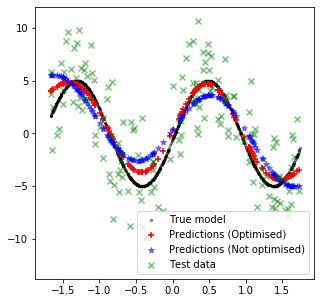

In [37]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_nlinTrue_std, y_nlinTrue, color='black',alpha=0.4, s=5, label='True model');
plt.scatter(x_nlin_test, TPnl_gp_opt_test['test_preds'], marker='+', color='r', label='Predictions (Optimised)')
plt.scatter(x_nlin_test, TPnl_gaussian_result['test_preds'], marker='*', color='b', label='Predictions (Not optimised)', alpha=0.5)
plt.scatter(x_nlin_test, y_nlin_test, marker='x', color='g', label='Test data', alpha=0.5);
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 7b - GP non-lin perf.png')

<a id='S224'></a>
### 2.2.4 K-means

In [38]:
# K-means without tuning k...
k = 10
TPnl_kmeans_result = k_means(x_nlin_train, y_nlin_train, x_nlin_test, y_nlin_test, k=k)
TPnl_kmeans_result_R2 = 1 - (TPnl_kmeans_result['Test RMSE'] / y_nlin_test.std())**2
print(f"K-means with arbitrary k:")
print(f" Train RMSE: {TPnl_kmeans_result['Train RMSE']:.02f}")
print(f" Test RMSE: {TPnl_kmeans_result['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_kmeans_result_R2:.02f}")

K-means with arbitrary k:
 Train RMSE: 3.44
 Test RMSE: 3.66
 Test R2: 0.47


In [39]:
# Tune k...
lb = [1]
ub = [100]
res = 100
start = time.time()
TPnl_kmeans_opt = brute_force_optimiser(k_means, 
                                      x_nlin_train, 
                                      y_nlin_train, 
                                      x_nlin_val, 
                                      y_nlin_val, 
                                      x_nlin_test, 
                                      y_nlin_test, 
                                      lb, 
                                      ub, 
                                      res=res)
TPnl_kmeans_opt_R2 = 1 - (TPnl_kmeans_opt['Test RMSE'] / y_nlin_test.std())**2
total_time = time.time() - start
print(f"K-means with tuned k:")
print(f" Optimal validate RMSE: {TPnl_kmeans_opt['Val RMSE']:.02f} using k of {TPnl_kmeans_opt['Optimal HP']:.00f}")
print(f" Corresponding test RMSE: {TPnl_kmeans_opt['Test RMSE']:.02f}")
print(f" Test R2: {TPnl_kmeans_opt_R2:.02f}")
print(f" Optimisation took {total_time:.02f} seconds for an R2 improvement of {TPnl_kmeans_opt_R2-TPnl_kmeans_result_R2:.02f} (+{(TPnl_kmeans_opt_R2-TPnl_kmeans_result_R2)*100/TPnl_kmeans_result_R2:0.2f}%)")

/Users/chrismcdonagh/Documents/Data Science /Machine Learning 1/Labs/ML-1-labs/Lab 5 (Project)/DL check/algorithms.py:383: RuntimeWarning: divide by zero encountered in true_divide
  [np.sum(1 / (distances[P == i])) for i in range(k)])


K-means with tuned k:
 Optimal validate RMSE: 3.25 using k of 23
 Corresponding test RMSE: 3.19
 Test R2: 0.60
 Optimisation took 6.11 seconds for an R2 improvement of 0.13 (+26.96%)


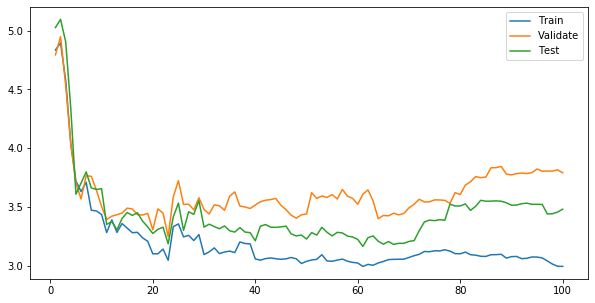

In [40]:
fig = plt.figure(figsize = (10, 5))
plt.plot(np.linspace(lb[0],ub[0],res),TPnl_kmeans_opt['RMSE plot'][:,0], label="Train");
plt.plot(np.linspace(lb[0],ub[0],res),TPnl_kmeans_opt['RMSE plot'][:,1], label="Validate");
plt.plot(np.linspace(lb[0],ub[0],res),TPnl_kmeans_opt['RMSE plot'][:,2], label="Test");
plt.legend();

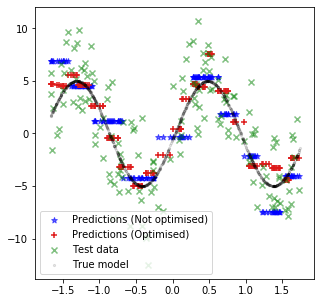

In [41]:
fig = plt.figure(figsize = (5, 5))
plt.scatter(x_nlin_test, TPnl_kmeans_result['test_preds'], marker='*', color='b', label='Predictions (Not optimised)', alpha=0.6)
plt.scatter(x_nlin_test, TPnl_kmeans_opt['test_preds'], marker='+', color='#DE1A1A', label='Predictions (Optimised)')
plt.scatter(x_nlin_test, y_nlin_test, marker='x', color='g', label='Test data', alpha=0.5);
plt.scatter(x_nlinTrue_std, y_nlinTrue, color='black', alpha=0.1, s=5,label='True model');
ax = plt.gca()
ax.grid(False)
plt.legend();

# plt.savefig('Figure 8b - kmeans non-lin perf.png')

<a id='S3'></a>
# 3. Summary

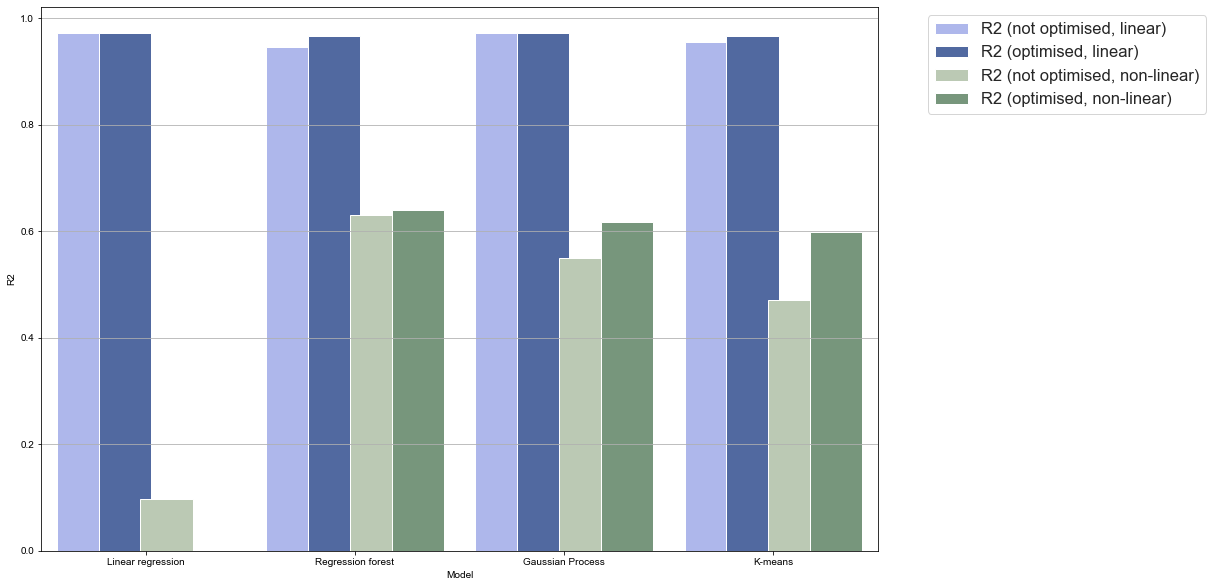

In [42]:
sum_TP_res_RMSE = {'Model': ['Linear regression', 'Regression forest', 'Gaussian Process', 'K-means'],
           'RMSE (not optimised, linear)': [TP_lin_reg_result['Test RMSE'], TP_reg_forest['Test RMSE'], 
                                    TP_gaussian_result['Test RMSE'], TP_kmeans_result['Test RMSE']],
           'RMSE (optimised, linear)': [TP_lin_reg_result_opt['Test RMSE'], TP_reg_forest_opt_test['Test RMSE'], 
                                    TP_gp_opt_test['Test RMSE'], TP_kmeans_opt['Test RMSE']],
            'RMSE (not optimised, non-linear)': [TPnl_lin_reg_result['Test RMSE'], TPnl_reg_forest['Test RMSE'], 
                                    TPnl_gaussian_result['Test RMSE'], TPnl_kmeans_result['Test RMSE']],
           'RMSE (optimised, non-linear)': [np.nan, TPnl_reg_forest_opt_test['Test RMSE'], 
                                    TPnl_gp_opt_test['Test RMSE'], TPnl_kmeans_opt['Test RMSE']]
          }
sum_TP_res_R2 = {'Model': ['Linear regression', 'Regression forest', 'Gaussian Process', 'K-means'],
           'R2 (not optimised, linear)': [TP_lin_reg_R2, TP_reg_forest_R2, 
                                    TP_gp_R2, TP_kmeans_result_R2],
           'R2 (optimised, linear)': [TP_lin_reg_opt_R2, TP_opt_reg_forest_R2, 
                                    TP_gp_opt_test_R2, TP_kmeans_opt_R2],
            'R2 (not optimised, non-linear)': [TPnl_lin_reg_R2, TPnl_reg_forest_R2, 
                                    TPnl_gp_R2, TPnl_kmeans_result_R2],
           'R2 (optimised, non-linear)': [np.nan, TPnl_opt_reg_forest_R2, 
                                    TPnl_gp_opt_test_R2, TPnl_kmeans_opt_R2],
          }
sum_res_df = pd.DataFrame(data = sum_TP_res_R2)
data = sum_res_df.melt(id_vars='Model').rename(columns=str.title)
clrs = ['#A4B0F5','#4464AD', '#BACDB0', '#729B79' ]
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.grid(True)
sns.set(style='whitegrid', font_scale=1.5)
results_plot = sns.barplot(data=data, x='Model', y='Value', hue='Variable', ax=ax1, palette=clrs);
ax1.set_ylabel('R2');
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Change the bar width...
        patch.set_width(new_value)

        # Recenter the bar....
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax1, 0.25)
#results_plot.axhline(y_lin_test.std(), color='#4464AD', linestyle='dotted', label="y_test std dev (linear)");
#results_plot.axhline(y_nlin_test.std(), color='#729B79', linestyle='dashed', label="y_test std dev (non linear)");
lgd = plt.legend(bbox_to_anchor=(1.05, 1));
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

# plt.savefig('Figure 9 - TP results summary.png', bbox_extra_artists=(lgd,), bbox_inches='tight')